In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/antoine/homhots/HOTS/HOTS


In [2]:
import os
import pickle
import datetime
from mix_Network import *

dataset = 'nmnist'
records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2020-12-21'
verbose = True

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = None
pooling = False
homeinv = False
jitter = False
tau = 5
krnlinit = 'first'
nblay = 3
nbclust = 4

ds = 75
nb_train = 7500//ds
nb_test = 2500//ds

In [3]:
def get_nmnist(NbTrainingData, NbTestingData):
    def loadev(nbdigit, loader, learningset):
        timout = []
        xout = []
        yout = []
        polout = []
        labout = []
        for i in range(NbTrainingData):
            events, target = next(iter(loader))
            for iev in range(events.shape[1]):
                    timout.append(events[0][iev][learningset.ordering.find("t")].item())
                    xout.append(events[0][iev][learningset.ordering.find("x")].item())
                    yout.append(events[0][iev][learningset.ordering.find("y")].item())
                    polout.append(events[0][iev][learningset.ordering.find("p")].item())
                    labout.append(target.item())

        eventsout = [xout,yout,timout,polout,labout,learningset.sensor_size,2]
        return eventsout
    
    learningset = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=False,
                                    transform=None)
    loader = tonic.datasets.DataLoader(learningset, shuffle=True)
    
    events_train = loadev(NbTrainingData, loader, learningset)
    events_test = loadev(NbTestingData, loader, learningset)
    
    return events_train, events_test

#### Building matrix for logistic regression
def gather_data(events_in,
                tau_cla=150, # characteristic time of a digit
                sample_events=50, sample_space = 1,
                verbose=False, debug=False):
    tau_cla *= 1e3 # to enter tau in ms
    n_events = len(events_in[0])

    c_int = lambda n, d : ((n - 1) // d) + 1
    
    data = np.zeros((c_int(events_in[-2][0], sample_space),
                     c_int(events_in[-2][1], sample_space),
                     events_in[-1])) #tmp data

    X = np.zeros((c_int(n_events, sample_events), len(data.ravel())))
    y = np.zeros((c_int(n_events, sample_events), ))

    for i_event in range(1, n_events):
        if events_in[2][i_event]<events_in[2][i_event-1]:
            data = np.zeros((c_int(events_in[-2][0], sample_space),
                     c_int(events_in[-2][1], sample_space),
                     events_in[-1])) #tmp data 

        data *= np.exp(-(events_in[2][i_event]-events_in[2][i_event-1])/tau_cla)
        
        x_pos = events_in[0][i_event]//sample_space
        y_pos = events_in[1][i_event]//sample_space
        p = events_in[3][i_event]
        data[int(x_pos), int(y_pos), int(p)] = 1.

        if i_event % sample_events == sample_events//2 :
            if debug:
                print(f'DEBUG {i_event} {i_event//sample_events} ')
                print(f'DEBUG {y[i_event//sample_events]}   ')
                print(f'DEBUG  {events_in[-3][i_event]} ')
            X[i_event//sample_events, :] = data.ravel()
            y[i_event//sample_events] = events_in[-3][i_event]
            
    if verbose: print('Number of events: ' + str(X.shape[0])+' - Number of features: ' + str(X.shape[1]))
    
    y_out = np.zeros([y.shape[0],int(max(y)+1)])
    for i in range(y.shape[0]):
        y_out[i,int(y[i])]=1
    
    return X, y_out

def get_events(tau, krnlinit, nblay, nbclust, homeo, records_path, timestr, dataset, sigma, homeinv, jitter, nb_train, nb_test):
    hotshom = network(krnlinit=krnlinit, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
    arch = [hotshom.L[i].kernel.shape[1] for i in range(len(hotshom.L))]
    fname = f'{records_path}/EXP_03_NMNIST/{timestr}_hots_{dataset}_{arch}_{tau}_{homeo}_{sigma}_{homeinv}_{jitter}'
    print(fname)
    if not os.path.isfile(fname+'_model.pkl'):
        loaderhom, order = hotshom.learning1by1(dataset=dataset)
        with open(fname+'_model.pkl', 'wb') as file:
            pickle.dump([hotshom, loaderhom, order], file, pickle.HIGHEST_PROTOCOL)
    else:
        with open(fname+'_model.pkl', 'rb') as file:
            hotshom, loaderhom, order = pickle.load(file)
            
    if not os.path.isfile(fname+f'_evout_{nb_train}_{nb_test}.pkl'):       
        _, loaderhom, out_train = hotshom.running(loaderhom, order, nb_digit = nb_train, LR=True)
        _, loaderhom, out_test = hotshom.running(loaderhom, order, nb_digit = nb_test, LR=True)
        with open(fname+f'_evout_{nb_train}_{nb_test}.pkl', 'wb') as file:
            pickle.dump([out_train, out_test], file, pickle.HIGHEST_PROTOCOL)
    else:
        with open(fname+f'_evout_{nb_train}_{nb_test}.pkl', 'rb') as file:
            out_train, out_test = pickle.load(file)
    return out_train, out_test


# ### Performingxlogistic regression
#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
#

# from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LogisticRegressionCV as LR
# 
opts_LR = dict(max_iter=2000, # random_state=0,
               n_jobs=-1, class_weight='balanced')
#opts_LR['Cs'] = 5
opts_LR['Cs'] = 32
# TODO for a publication use 100 from 10^{-10} to 10

from sklearn.model_selection import train_test_split

def tic():
    global ttic
    ttic = time.time()
def toc():
    print(f'Done in {time.time() - ttic:.3f} s')

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        self.nl = torch.nn.LogSoftmax(dim=1)

    def forward(self, factors):
        return self.nl(torch.squeeze(self.linear(factors),dim=1))

In [33]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(factors, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device -> {device}')
    
    N_batch = factors.shape[0]
    N = factors.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            target = torch.argmax(torch.squeeze(labels_,dim=1), 1)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")
            
    logistic_model.eval()
    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    X, labels = X.to(device), labels.to(device)
    outputs = logistic_model(X)
    target = torch.argmax(torch.squeeze(labels,dim=1), 1)
    loss = criterion(outputs, target).item()
    return logistic_model, loss

def predict_data(factors, y, model,
            batch_size=batch_size,  # gamma=gamma,
            verbose=False, **kwargs
        ):
    batch_size = 1
    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device -> {device}')

    logistic_model = model.to(device)
    
    losses = []
    acc = 0
    for X_, labels_ in loader:
        X_, labels_ = X_.to(device), labels_.to(device)
        output = logistic_model(X_)
        target = torch.argmax(torch.squeeze(labels_,dim=1), 1)
        loss = criterion(output, target)
        losses.append(loss.item())
        pred = torch.argmax(torch.tensor(output), dim=1)
        if pred.item()==target.item():
            acc+=1
    accuracy = acc/y.shape[0]
    return losses, accuracy

In [31]:
tic()
events_train, events_test = get_nmnist(nb_train, nb_test)
toc()

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/
Done in 21.079 s


In [7]:
tic()
X_train, y_train = gather_data(events_train, verbose=verbose)
toc()

Number of events: 8424 - Number of features: 2312
Done in 1.940 s


In [8]:
N = X_train.shape[1]

logistic_model = LogisticRegressionModel(N, n_classes)

logistic_model, loss = fit_data(X_train, y_train, verbose=True)
print("Final loss =", loss)

device -> cuda
Iteration: 0 - Loss: 0.59200
Iteration: 16 - Loss: 0.00877
Iteration: 32 - Loss: 0.00463
Iteration: 48 - Loss: 0.00312
Iteration: 64 - Loss: 0.00238
Iteration: 80 - Loss: 0.00192
Iteration: 96 - Loss: 0.00159
Iteration: 112 - Loss: 0.00136
Iteration: 128 - Loss: 0.00118
Iteration: 144 - Loss: 0.00105
Iteration: 160 - Loss: 0.00093
Iteration: 176 - Loss: 0.00085
Iteration: 192 - Loss: 0.00077
Iteration: 208 - Loss: 0.00070
Iteration: 224 - Loss: 0.00065
Iteration: 240 - Loss: 0.00060
Iteration: 256 - Loss: 0.00056
Iteration: 272 - Loss: 0.00052
Iteration: 288 - Loss: 0.00049
Iteration: 304 - Loss: 0.00046
Iteration: 320 - Loss: 0.00043
Iteration: 336 - Loss: 0.00041
Iteration: 352 - Loss: 0.00039
Iteration: 368 - Loss: 0.00037
Iteration: 384 - Loss: 0.00035
Iteration: 400 - Loss: 0.00033
Iteration: 416 - Loss: 0.00032
Iteration: 432 - Loss: 0.00031
Iteration: 448 - Loss: 0.00029
Iteration: 464 - Loss: 0.00028
Iteration: 480 - Loss: 0.00027
Iteration: 496 - Loss: 0.00026
I

In [34]:
X_test, y_test = gather_data(events_test, verbose=verbose)
loss, accuracy = predict_data(X_test, y_test, logistic_model)
print(round(np.mean(loss),3), round(accuracy,2))

Number of events: 8510 - Number of features: 2312
device -> cuda


<ipython-input-33-a50d66b9e8e7>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.argmax(torch.tensor(output), dim=1)


1.8336660537479885 0.6340775558166862


8377


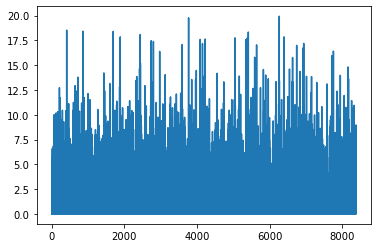

In [20]:
print(len(loss))
plt.plot(range(X_test.shape[0]), loss)

In [35]:
events_train_o, events_test_o = get_events(tau, krnlinit, nblay, nbclust, homeo, records_path, timestr, dataset, sigma, homeinv, jitter, nb_train, nb_test)
X_train, y_train = gather_data(events_train_o, verbose=verbose)

n_classes = y_train.shape[1]
N = X_train.shape[1]

logistic_model = LogisticRegressionModel(N, n_classes)

logistic_model, loss = fit_data(X_train, y_train, verbose=True)
print("Final loss =", loss)

../Records/EXP_03_NMNIST/2020-12-21_hots_nmnist_[4, 8, 16]_5_True_None_False_False
Number of events: 7879 - Number of features: 18496
device -> cuda
Iteration: 0 - Loss: 0.22358
Iteration: 16 - Loss: 0.00411
Iteration: 32 - Loss: 0.00208
Iteration: 48 - Loss: 0.00126
Iteration: 64 - Loss: 0.00083
Iteration: 80 - Loss: 0.00061
Iteration: 96 - Loss: 0.00047
Iteration: 112 - Loss: 0.00037
Iteration: 128 - Loss: 0.00031
Iteration: 144 - Loss: 0.00027
Iteration: 160 - Loss: 0.00023
Iteration: 176 - Loss: 0.00021
Iteration: 192 - Loss: 0.00019
Iteration: 208 - Loss: 0.00017
Iteration: 224 - Loss: 0.00015
Iteration: 240 - Loss: 0.00014
Iteration: 256 - Loss: 0.00013
Iteration: 272 - Loss: 0.00012
Iteration: 288 - Loss: 0.00011
Iteration: 304 - Loss: 0.00011
Iteration: 320 - Loss: 0.00010
Iteration: 336 - Loss: 0.00009
Iteration: 352 - Loss: 0.00009
Iteration: 368 - Loss: 0.00009
Iteration: 384 - Loss: 0.00008
Iteration: 400 - Loss: 0.00008
Iteration: 416 - Loss: 0.00007
Iteration: 432 - Loss:

In [37]:
X_test, y_test = gather_data(events_test_o, verbose=verbose)
loss, accuracy = predict_data(X_test, y_test, logistic_model)
print(round(np.mean(loss),3), round(accuracy,2))

Number of events: 2765 - Number of features: 18496
device -> cuda


<ipython-input-33-a50d66b9e8e7>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.argmax(torch.tensor(output), dim=1)


1.214 0.7
